<a href="https://colab.research.google.com/github/VietAnh954/Plant-Status-Classification-based-on-Leaf-Color-Features-and-Sensor-Data-ML-/blob/main/2_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# [Cell 1] - KHỞI TẠO VÀ CÀI ĐẶT
import cv2
import numpy as np
import os
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Drive (Vì là file mới nên phải mount lại)
drive.mount('/content/drive')

# Đường dẫn đến thư mục chứa ảnh (Sửa lại đúng path của bạn nếu khác)
dataset_path = "/content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/dataPlantVillage/Raw_Data_PlantVillage/PlantVillage"
# Nơi lưu file CSV kết quả
output_csv_path = "/content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/dataPlantVillage/leaf_features_final.csv"

print("✅ Đã sẵn sàng xử lý!")

Mounted at /content/drive
✅ Đã sẵn sàng xử lý!


In [2]:
# [Cell 2] - HÀM XỬ LÝ ẢNH CHUYÊN SÂU (CORE ENGINE)
# Đây là "trái tim" của thuật toán. Đọc kỹ chú thích để hiểu Master đang làm gì.

def process_leaf_image(image_path):
    try:
        # 1. Đọc ảnh
        img = cv2.imread(image_path)
        if img is None: return None

        # Resize nhỏ lại chút cho xử lý nhanh (ví dụ 256x256)
        img = cv2.resize(img, (256, 256))

        # Chuyển sang hệ màu HSV (Hue, Saturation, Value)
        # HSV tách biệt màu sắc (H) khỏi độ sáng (V), giúp nhận diện màu tốt hơn RGB
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # 2. TÁCH NỀN (SEGMENTATION)
        # Nền màu xám thường có Saturation (Độ bão hòa màu) rất thấp.
        # Lá cây (xanh, vàng, nâu) đều có Saturation cao hơn nền.

        # Tạo mask: Lấy những vùng có độ bão hòa > 25 (Loại bỏ màu xám)
        # Và độ sáng > 25 (Loại bỏ vùng quá tối/đen kịt của nền)
        mask = cv2.inRange(hsv, np.array([0, 25, 25]), np.array([179, 255, 255]))

        # Đếm tổng số pixel của cái lá (Diện tích lá)
        leaf_area = cv2.countNonZero(mask)
        if leaf_area == 0: return None # Không tìm thấy lá

        # 3. TRÍCH XUẤT MÀU SẮC TRÊN VÙNG LÁ (MASKED AREA)
        # Chỉ xét những pixel nằm trong vùng mask (tức là pixel của lá)

        # --- Định nghĩa dải màu (Đây là kinh nghiệm xương máu của Master) ---
        # OpenCV Hue range: 0-179

        # MÀU NÂU (Bệnh/Cháy): Hue thường < 20 hoặc > 160, và hơi tối
        lower_brown1 = np.array([0, 40, 20])
        upper_brown1 = np.array([25, 255, 200]) # Nâu/Cam đất
        lower_brown2 = np.array([160, 40, 20])
        upper_brown2 = np.array([179, 255, 200]) # Đỏ nâu

        # MÀU VÀNG (Úa/Virus): Hue khoảng 26 - 35
        lower_yellow = np.array([26, 40, 40])
        upper_yellow = np.array([35, 255, 255])

        # MÀU XANH (Khỏe): Hue khoảng 36 - 85
        lower_green = np.array([36, 40, 40])
        upper_green = np.array([85, 255, 255])

        # --- Tạo mask cho từng màu ---
        mask_brown1 = cv2.inRange(hsv, lower_brown1, upper_brown1)
        mask_brown2 = cv2.inRange(hsv, lower_brown2, upper_brown2)
        mask_brown = cv2.bitwise_or(mask_brown1, mask_brown2)
        # Chỉ lấy màu nâu NẰM TRONG hình cái lá
        mask_brown = cv2.bitwise_and(mask_brown, mask)

        mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
        mask_yellow = cv2.bitwise_and(mask_yellow, mask)

        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        mask_green = cv2.bitwise_and(mask_green, mask)

        # 4. TÍNH TỶ LỆ PHẦN TRĂM
        brown_pixels = cv2.countNonZero(mask_brown)
        yellow_pixels = cv2.countNonZero(mask_yellow)
        green_pixels = cv2.countNonZero(mask_green)

        # Các màu khác (đốm lạ, trắng...)
        other_pixels = leaf_area - (brown_pixels + yellow_pixels + green_pixels)

        # Tính %
        pct_brown = (brown_pixels / leaf_area) * 100
        pct_yellow = (yellow_pixels / leaf_area) * 100
        pct_green = (green_pixels / leaf_area) * 100

        # 5. GÁN NHÃN MÀU SẮC (Cái này để dùng cho input thủ công của bạn)
        # Logic ưu tiên: Nếu có đốm nâu nhiều -> Nâu. Nếu vàng nhiều -> Vàng. Còn lại Xanh.
        final_color = "Xanh"

        # Ngưỡng phát hiện bệnh (Nâu/Hoại tử): Hạ xuống 2%
        # Vì mắt người rất nhạy với đốm đen trên nền xanh
        if pct_brown > 2.0:
            final_color = "Nau/Dom"

        # Ngưỡng phát hiện úa (Vàng): Hạ xuống 7%
        # Lá bắt đầu vàng là dấu hiệu sớm, cần cảnh báo ngay
        elif pct_yellow > 7.0:
            final_color = "Vang"
        else:
            final_color = "Xanh"

        return [pct_green, pct_yellow, pct_brown, final_color]

    except Exception as e:
        print(f"Lỗi: {e}")
        return None



[72.01863653920432, 16.929799150251064, 0.48764001544998065, 'Vang']


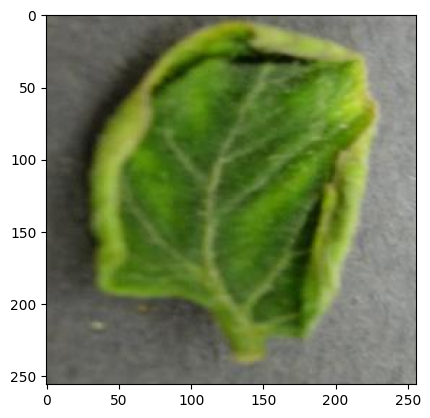

In [3]:
# Test thử 1 ảnh để bạn xem kết quả ngay
# Hãy thay đường dẫn dưới đây bằng 1 file ảnh thật bất kỳ trong drive của bạn để test
img_test = "/content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/dataPlantVillage/Raw_Data_PlantVillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0d613c80-738a-42da-834f-7db6203018ff___UF.GRC_YLCV_Lab 02393.JPG"
print(process_leaf_image(img_test))
img = cv2.imread(img_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

🚀 Đang bắt đầu quét toàn bộ dataset...
📂 Đang xử lý lớp: Pepper__bell___Bacterial_spot...
📂 Đang xử lý lớp: Pepper__bell___healthy...
📂 Đang xử lý lớp: Potato___Early_blight...
📂 Đang xử lý lớp: Potato___Late_blight...
📂 Đang xử lý lớp: Potato___healthy...
📂 Đang xử lý lớp: Tomato_Bacterial_spot...
📂 Đang xử lý lớp: Tomato_Early_blight...
📂 Đang xử lý lớp: Tomato_Late_blight...
📂 Đang xử lý lớp: Tomato_Leaf_Mold...
📂 Đang xử lý lớp: Tomato_Septoria_leaf_spot...
📂 Đang xử lý lớp: Tomato_Spider_mites_Two_spotted_spider_mite...
📂 Đang xử lý lớp: Tomato__Target_Spot...
📂 Đang xử lý lớp: Tomato__Tomato_YellowLeaf__Curl_Virus...
📂 Đang xử lý lớp: Tomato__Tomato_mosaic_virus...
📂 Đang xử lý lớp: Tomato_healthy...

🎉 HOÀN TẤT! Đã xử lý 7025 ảnh.
⏱️ Thời gian thực hiện: 539.07 giây
💾 File dữ liệu đã lưu tại: /content/drive/MyDrive/Colab Notebooks/ML/NEW PLAN/dataPlantVillage/leaf_features_final.csv
                                          Image_Name  \
0  c9e13908-bce6-4ad7-831f-a4a408cabf72__

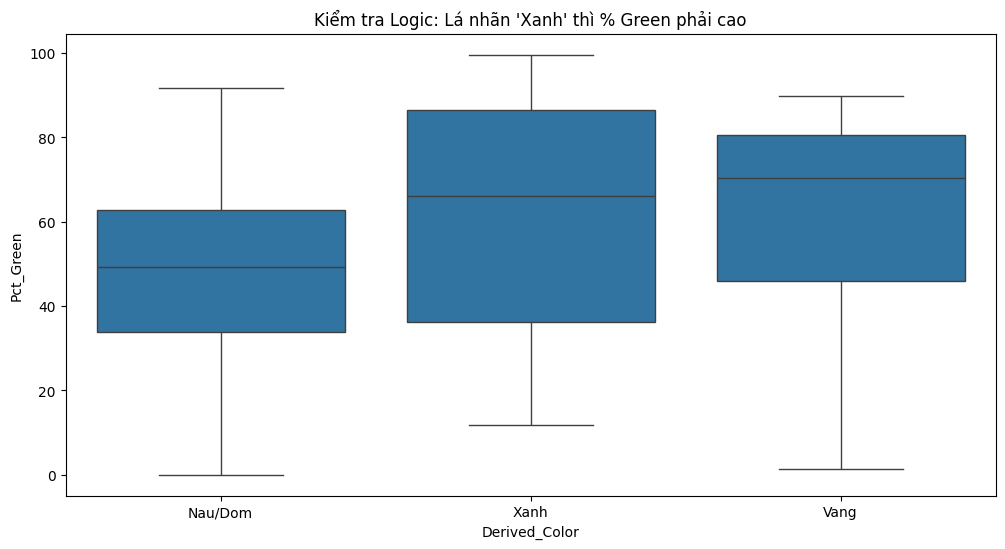

In [4]:
# [Cell 3] - CHẠY VÒNG LẶP QUÉT TOÀN BỘ DATASET (BATCH PROCESSING)
import time

data_list = []
start_time = time.time()

print("🚀 Đang bắt đầu quét toàn bộ dataset...")

# Duyệt qua từng folder lớp
classes = sorted(os.listdir(dataset_path))

for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_dir): continue

    print(f"📂 Đang xử lý lớp: {class_name}...")

    # Lấy danh sách ảnh
    images = os.listdir(class_dir)
    # Lấy mẫu tối đa 500 ảnh mỗi lớp thôi để chạy cho nhanh (hoặc lấy hết nếu bạn kiên nhẫn)
    # Vì mục đích là tạo dataset bảng, 500 mẫu/lớp là quá đủ.
    # Nếu lớp nào ít hơn 500 thì lấy hết.
    images_to_process = images[:500]

    for img_name in images_to_process:
        img_path = os.path.join(class_dir, img_name)

        # Gọi hàm xử lý
        features = process_leaf_image(img_path)

        if features:
            # features = [pct_green, pct_yellow, pct_brown, final_color]
            # Lưu thêm thông tin nhãn gốc (Ground Truth) để sau này đối chiếu
            row = {
                "Image_Name": img_name,
                "Original_Class": class_name,
                "Pct_Green": features[0],
                "Pct_Yellow": features[1],
                "Pct_Brown": features[2],
                "Derived_Color": features[3] # Đây là cột "Màu lá" bạn sẽ dùng
            }
            data_list.append(row)

# Tạo DataFrame
df_features = pd.DataFrame(data_list)

# Lưu xuống file
df_features.to_csv(output_csv_path, index=False)

end_time = time.time()
print("\n" + "="*50)
print(f"🎉 HOÀN TẤT! Đã xử lý {len(df_features)} ảnh.")
print(f"⏱️ Thời gian thực hiện: {round(end_time - start_time, 2)} giây")
print(f"💾 File dữ liệu đã lưu tại: {output_csv_path}")
print("="*50)

# Hiển thị 10 dòng đầu tiên để kiểm tra
print(df_features.head(10))

# Vẽ biểu đồ kiểm tra xem màu sắc trích xuất có hợp lý không
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_features, x='Derived_Color', y='Pct_Green')
plt.title("Kiểm tra Logic: Lá nhãn 'Xanh' thì % Green phải cao")
plt.show()